<a href="https://colab.research.google.com/github/zarco90/Formation/blob/main/C4/W4/ungraded_labs/C4_W4_Lab_2_Sunspots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [2]:
#!pip install tensorflow==2.5.0

In [3]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [4]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [5]:
# Sunspots.csv
!gdown --id 1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5

Downloading...
From: https://drive.google.com/uc?id=1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5
To: /content/Sunspots.csv
100% 70.8k/70.8k [00:00<00:00, 65.0MB/s]


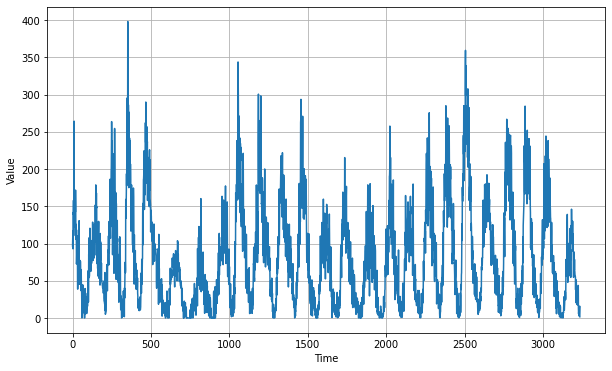

In [6]:
import csv
time_step = []
sunspots = []

with open('./Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

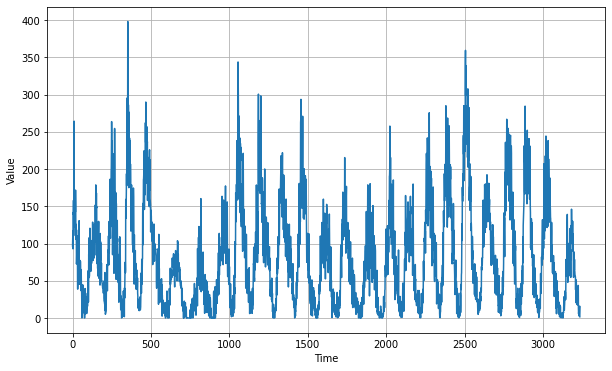

In [7]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [8]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [10]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 15s 84ms/step - loss: 79.8340 - mae: 80.3314 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 1s 54ms/step - loss: 78.0944 - mae: 78.5918 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 1s 55ms/step - loss: 75.4519 - mae: 75.9497 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 1s 57ms/step - loss: 72.2679 - mae: 72.7658 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 1s 57ms/step - loss: 68.7693 - mae: 69.2672 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 1s 54ms/step - loss: 65.1128 - mae: 65.6099 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 1s 58ms/step - loss: 61.5272 - mae: 62.0241 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============================] - 1s 57ms/step - loss: 58.1406 - mae: 58.6369 - 

(1e-08, 0.0001, 0.0, 60.0)

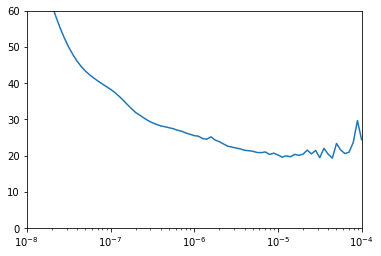

In [12]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 5s 37ms/step - loss: 38.9198 - mae: 39.4161
Epoch 2/500
30/30 [==============================] - 1s 35ms/step - loss: 25.7735 - mae: 26.2680
Epoch 3/500
30/30 [==============================] - 1s 36ms/step - loss: 22.0759 - mae: 22.5697
Epoch 4/500
30/30 [==============================] - 1s 36ms/step - loss: 20.4693 - mae: 20.9623
Epoch 5/500
30/30 [==============================] - 1s 36ms/step - loss: 19.7640 - mae: 20.2564
Epoch 6/500
30/30 [==============================] - 1s 37ms/step - loss: 19.3092 - mae: 19.8014
Epoch 7/500
30/30 [==============================] - 1s 36ms/step - loss: 18.7371 - mae: 19.2292
Epoch 8/500
30/30 [==============================] - 1s 35ms/step - loss: 18.1141 - mae: 18.6057
Epoch 9/500
30/30 [==============================] - 1s 36ms/step - loss: 18.0803 - mae: 18.5719
Epoch 10/500
30/30 [==============================] - 1s 36ms/step - loss: 17.9086 - mae: 18.4000
Epoch 11/500
30/30 [=========

In [14]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

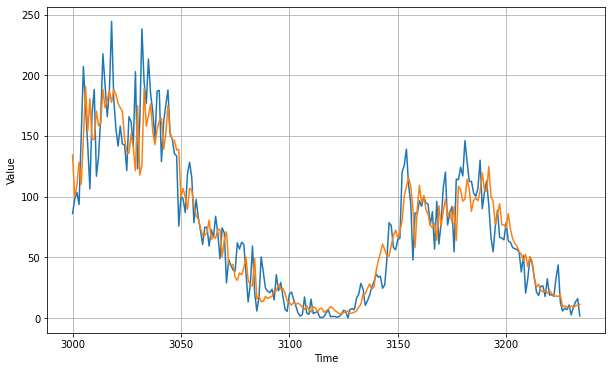

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

14.93128

<Figure size 432x288 with 0 Axes>

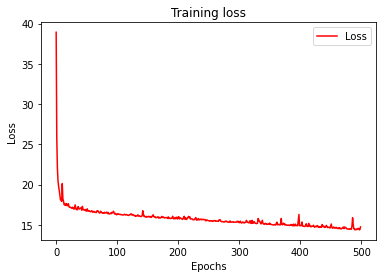

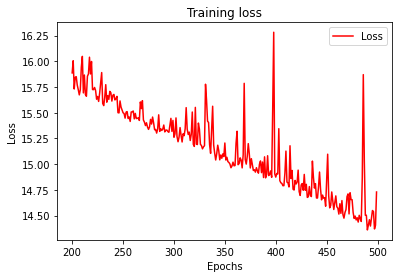

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [18]:
print(rnn_forecast)

[134.27481    99.73973   109.35686   128.35352   110.05794   147.92183
 190.80933   153.95505   180.53836   146.6719    147.43126   170.2721
 158.39574   160.54381   188.4131    173.24268   179.44714   187.46553
 177.50327   188.39542   184.2708    176.719     173.168     170.1436
 147.50397   136.61725   135.7312    151.58443   140.4228    121.330086
 174.82913   117.69339   126.10892   189.01904   158.12952   166.42116
 176.39929   153.17677   142.76363   155.67697   162.37926   164.26105
 139.01462   151.51826   175.08199   153.08844   146.6901    146.21936
 138.32208   138.96457    99.41626   106.66724    99.42744    89.64107
 106.73468   105.186      93.151535   84.00748    81.53372    74.175026
  67.81377    68.06564    70.35172    80.59061    64.73012    67.25875
  65.80581    73.30411    72.79992    50.180946   64.20971    71.05687
  44.617405   43.38147    44.128235   33.402225   31.0533     37.12992
  35.593746   41.55337    50.231434   31.024817   27.40562    26.455683
  48.